# Cutting the tests

# Purpose
Cut the tests based on their states.

# Methodology
Look at the velocities, accelerations and rudder signal to determine the good parts of the tests

# Setup

In [1]:
# %load imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp
import seaborn as sns

## Local packages:
from vessel_manoeuvring_models.data import mdl




Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


In [2]:
df_runs = mdl.runs()

In [3]:
mask = ((~df_runs['sailing']) &
        (
            (df_runs['test_type'] == 'reference speed') |
            (df_runs['test_type'] == 'rodergrundvinkel') |
            ((df_runs['series_number'] == 5) & (df_runs['test_number'] == 1)  & (df_runs['run_number'] == 3)) |
            ((df_runs['series_number'] == 5) & (df_runs['test_number'] == 2)  & (df_runs['run_number'] == 6)) |
            ((df_runs['series_number'] == 5) & (df_runs['test_number'] == 3)  & (df_runs['run_number'] == 2)) |
            ((df_runs['series_number'] == 5) & (df_runs['test_number'] == 4)  & (df_runs['run_number'] == 1)) |
            ((df_runs['series_number'] == 5) & (df_runs['test_number'] == 5)  & (df_runs['run_number'] == 1)) 
            
       ))
df_runs_selected = df_runs.loc[mask].copy()

In [4]:
def load_run(id):
    
    df, units, meta_data = mdl.load(id=id, dir_path='../data/processed/kalman')
    df.index = df.index.total_seconds()
    df.index-=df.index[0]
    df.sort_index(inplace=True)
    df['-delta'] = -df['delta']
    df['V'] = np.sqrt(df['u']**2 + df['v']**2)
    
    return df, units, meta_data

df_all = pd.DataFrame()
for id,row in df_runs_selected.iterrows():
    
    df_, units, meta_data = load_run(id)
    df_['id'] = id
    df_['t'] = df_.index
    df_all = df_all.append(df_, ignore_index=True)

    
df_all['thrust'] = df_all['Prop/PS/Thrust'] + df_all['Prop/SB/Thrust']
df_all['U'] = df_all['V']

df_all_clean = df_all.copy()
df_all = pd.merge(left=df_all, right = df_runs_selected, how='left', left_on='id', right_index=True)

In [5]:
ref_runs = df_all.groupby(by='test_type').get_group('reference speed')
runs = ref_runs.groupby(by='id')
df_cut = pd.DataFrame()
for id, group in runs:
    
    df_rolling = group.rolling(window=500).std()
    mask = df_rolling['u1d'] < 0.0004
    df_ = group.loc[mask].copy()
    if len(df_) > 300:
        df_cut = df_cut.append(df_)
    
    

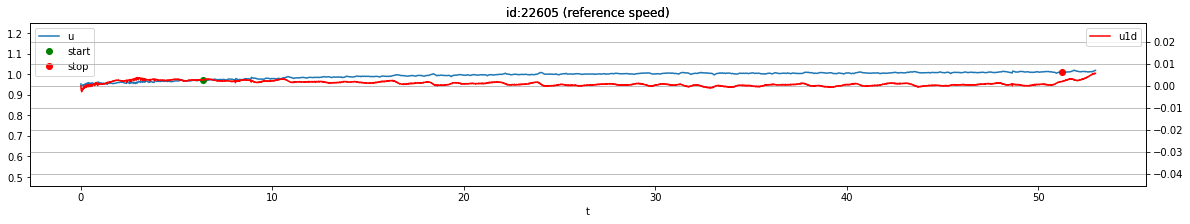

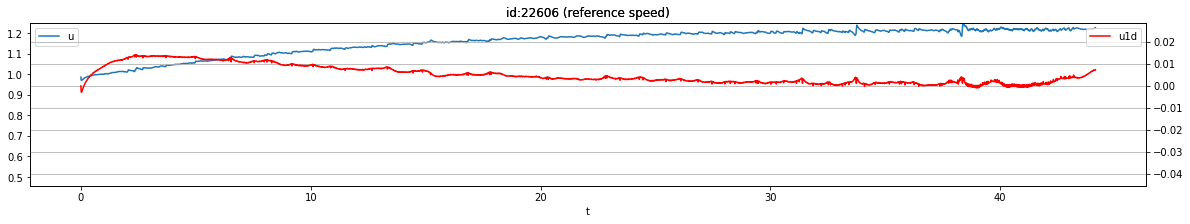

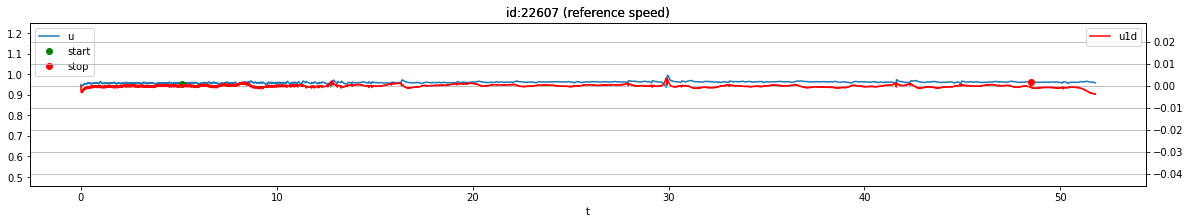

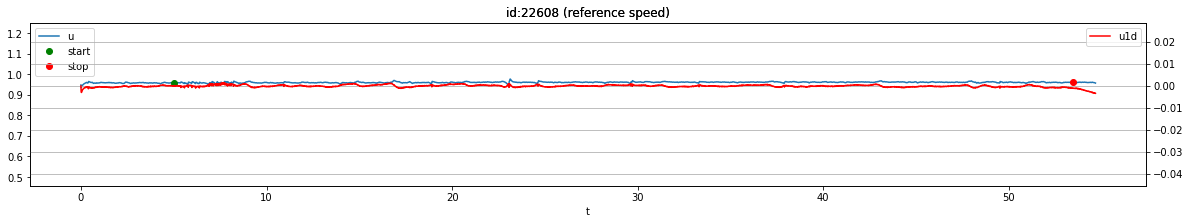

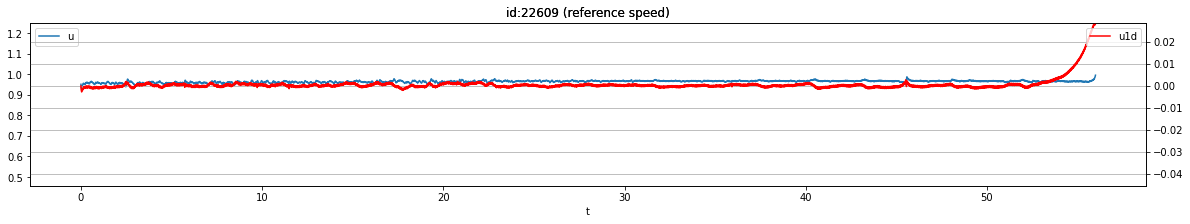

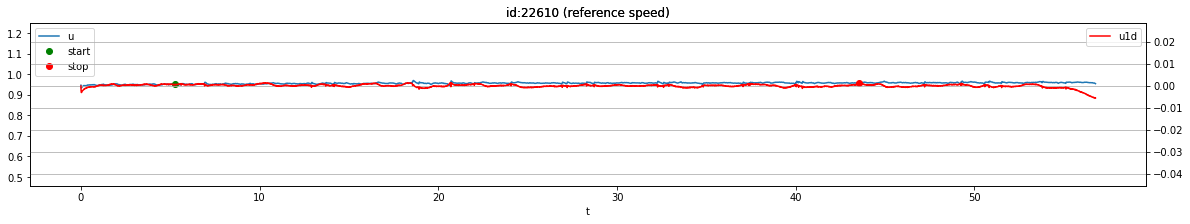

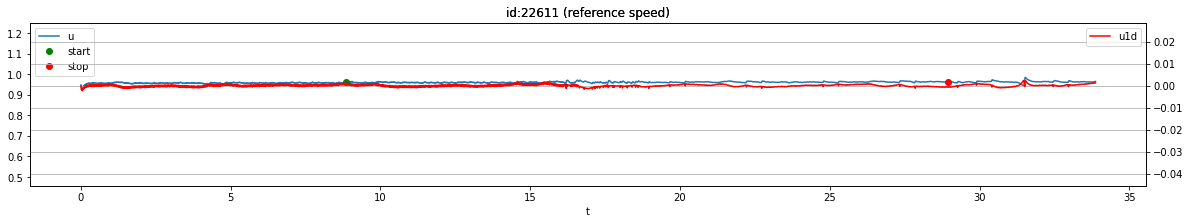

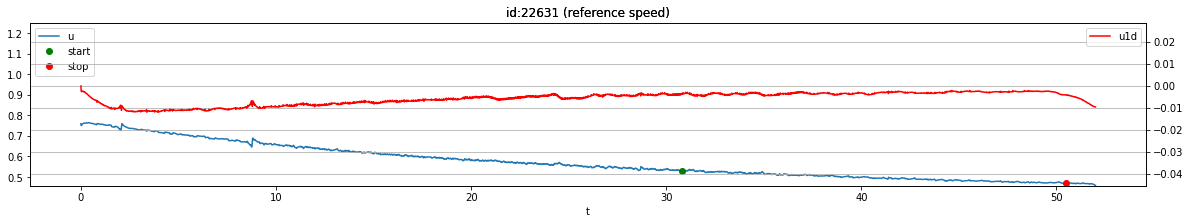

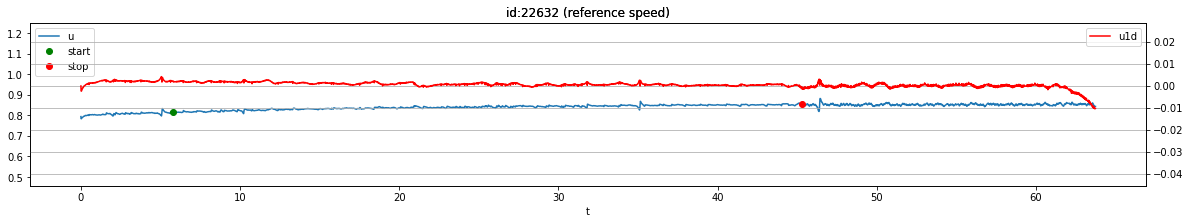

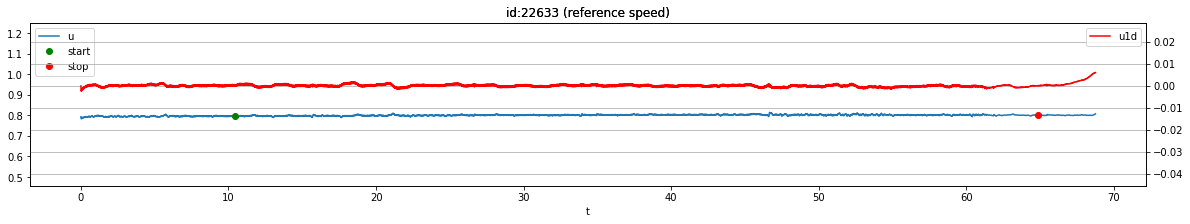

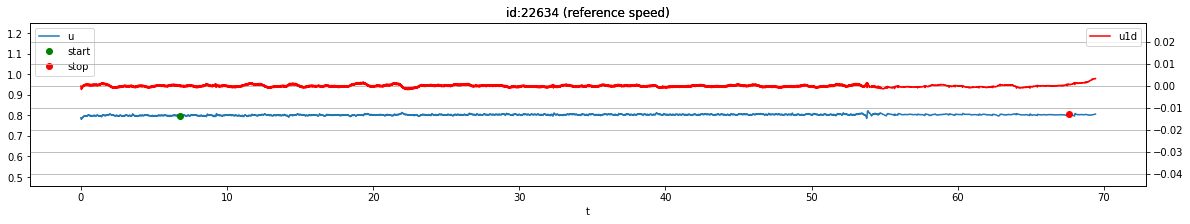

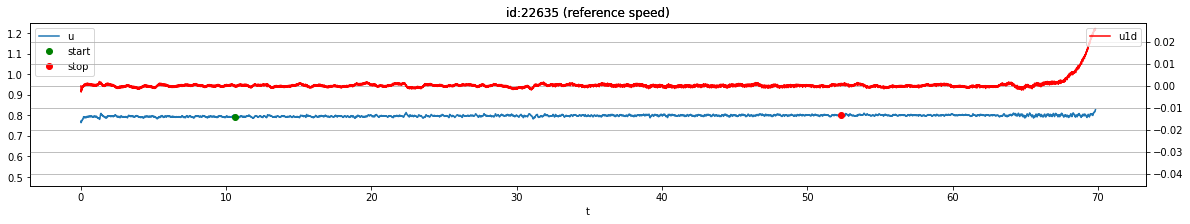

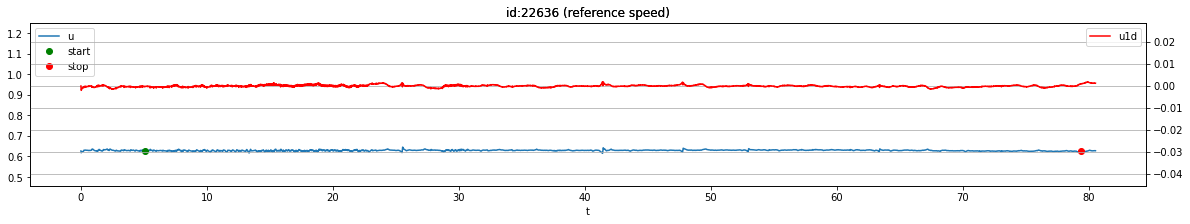

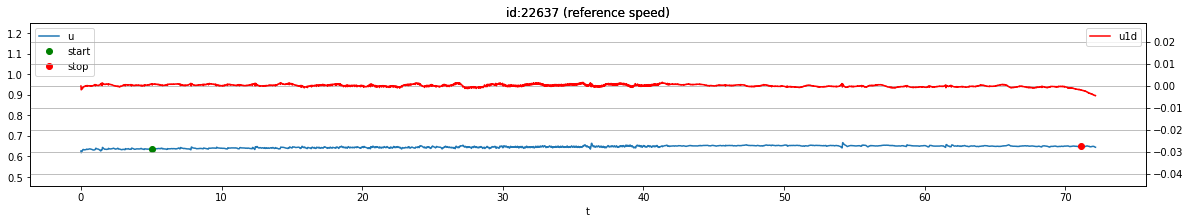

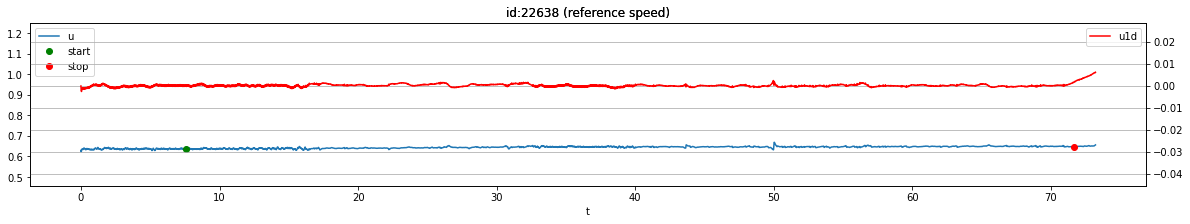

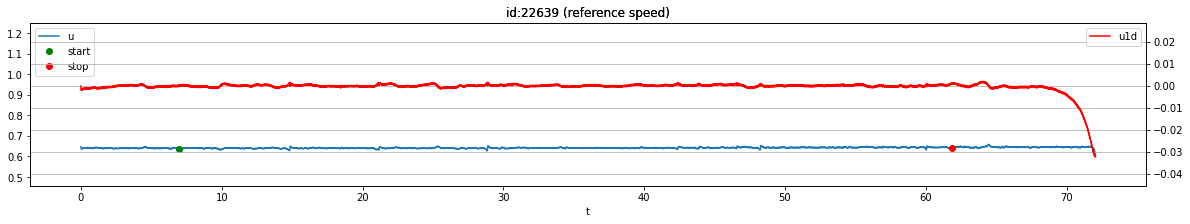

In [6]:
runs_cut = df_cut.groupby(by='id')
for id, group in runs:
    
    fig,ax=plt.subplots()
    fig.set_size_inches(20,3)
    
    meta_data = df_runs_selected.loc[id]
    title = f'id:{id} ({meta_data["test_type"]})'
    ax.set_title(title)
    
    key='u'
    group.plot(x='t', y=key,ax=ax)
    
    try: 
        group_cut = runs_cut.get_group(id)
    except:
        pass
    else:
        group_cut.iloc[[0]].plot(x='t', y=key, style='go', label='start', ax=ax)
        group_cut.iloc[[-1]].plot(x='t', y=key, style='ro', label='stop', ax=ax)
        
    ax.set_ylim(df_all[key].min(),df_all[key].max())
    ax.legend(loc='upper left')
    
    ax2 = ax.twinx()
    key='u1d'
    group.plot(x='t', y=key,ax=ax2, style='r-', title=title)
        
    ax2.set_ylim(df_all[key].min(),df_all[key].max())
    ax2.get_legend().set_visible(False)
    ax2.legend(loc='upper right')
    ax2.grid(True)
    

In [7]:
ref_rud_runs = df_all.groupby(by='test_type').get_group('rodergrundvinkel')
runs = ref_rud_runs.groupby(by='id')

for id, group in runs:
    
    df_rolling = group.rolling(window=500).std()
    mask = ((df_rolling['r'] < 0.0004) & (df_rolling['u1d'] < 0.0005))
    df_ = group.loc[mask].copy()
    
    df_ = group.loc[mask].copy()
    if len(df_) > 300:
        df_cut = df_cut.append(df_)

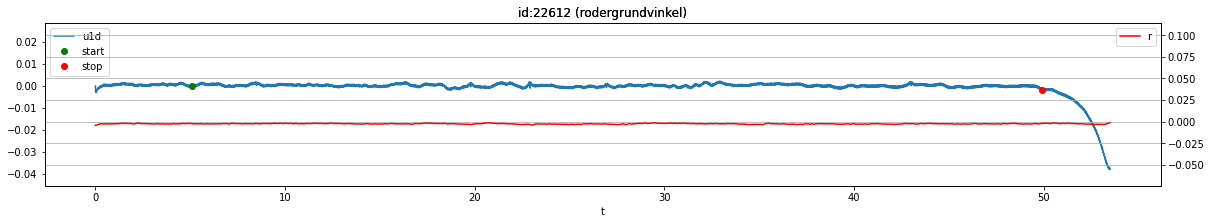

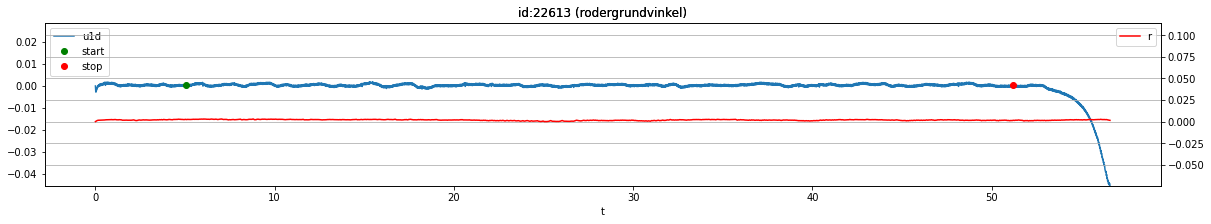

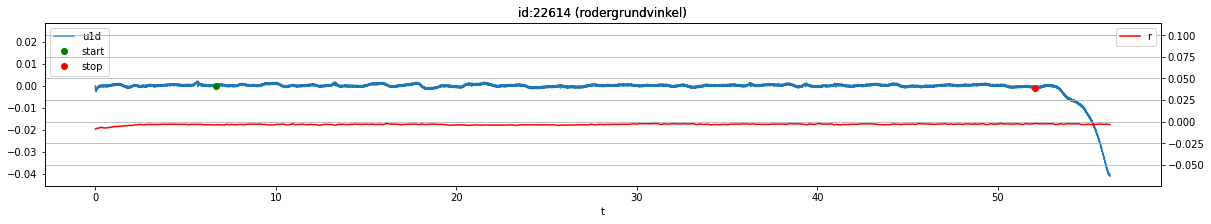

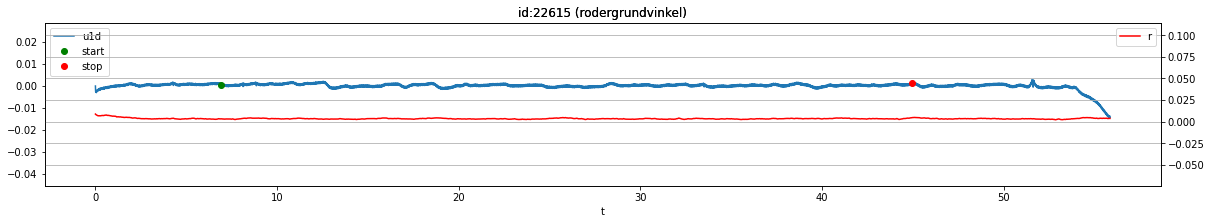

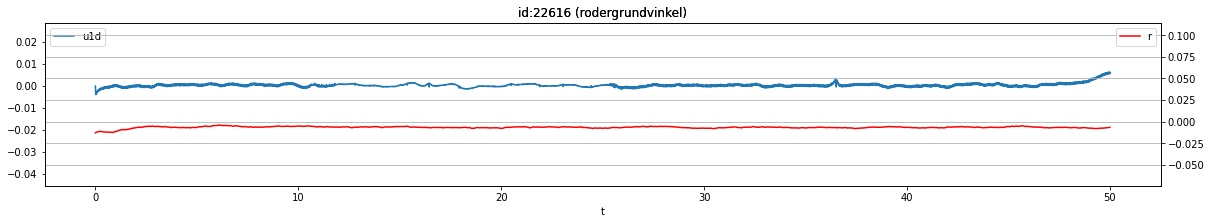

In [8]:
runs_cut = df_cut.groupby(by='id')
for id, group in runs:
    
    fig,ax=plt.subplots()
    fig.set_size_inches(20,3)
    
    meta_data = df_runs_selected.loc[id]
    title = f'id:{id} ({meta_data["test_type"]})'
    ax.set_title(title)
    
    key='u1d'
    group.plot(x='t', y=key,ax=ax)
    
    try: 
        group_cut = runs_cut.get_group(id)
    except:
        pass
    else:
        group_cut.iloc[[0]].plot(x='t', y=key, style='go', label='start', ax=ax)
        group_cut.iloc[[-1]].plot(x='t', y=key, style='ro', label='stop', ax=ax)
        
    ax.set_ylim(df_all[key].min(),df_all[key].max())
    ax.legend(loc='upper left')
    
    ax2 = ax.twinx()
    key='r'
    group.plot(x='t', y=key,ax=ax2, style='r-', title=title)
        
    ax2.set_ylim(df_all[key].min(),df_all[key].max())
    ax2.get_legend().set_visible(False)
    ax2.legend(loc='upper right')
    ax2.grid(True)

In [9]:
mask = ((df_all['test_type']=='reference speed') | 
        (df_all['test_type']=='rodergrundvinkel')
       )
df_man = df_all.loc[~mask]
for id,group in df_man.groupby(by='id'):
    df_ = group.iloc[0:-500].copy()  # "strange thing may happen in the end"
    df_cut = df_cut.append(df_)

In [10]:
df_cut['test_type'].unique()

array(['reference speed', 'rodergrundvinkel', 'zigzag', 'turning circle'],
      dtype=object)

In [11]:
df_cut

,Arr/Ind/Arr,Arr/Ind/Fri,Fan/Aft/Angle,Fan/Aft/AngleOrder,Fan/Aft/Fx,Fan/Aft/Rpm,Fan/Aft/RpmOrder,Fan/Fore/Angle,Fan/Fore/AngleOrder,Fan/Fore/Fx,Fan/Fore/Rpm,Fan/Fore/RpmOrder,Hull/Acc/X1,Hull/Acc/Y1,Hull/Acc/Y2,Hull/Acc/Z1,Hull/Acc/Z2,Hull/Acc/Z3,Prop/PS/Rpm,Prop/PS/Thrust,Prop/PS/Torque,Prop/SB/Rpm,Prop/SB/Thrust,Prop/SB/Torque,delta,Rudder/MaxAngle,Rudder/Rate,lab/WaveHeight,roll,pitch,psi,x0,y0,z0,x01d_gradient,y01d_gradient,z01d_gradient,x02d_gradient,y02d_gradient,z02d_gradient,psi1d_gradient,psi2d_gradient,x0_filtered,x01d,x02d,y0_filtered,y01d,y02d,psi_filtered,psi1d,psi2d,u,v,w,u1d,v1d,w1d,r,r1d,beta,u_gradient,v_gradient,w_gradient,u1d_gradient,v1d_gradient,w1d_gradient,r_gradient,r1d_gradient,-delta,V,id,t,Fan/Aft/FxOrder,Fan/ForceFactor,Fan/Fore/AngleOrder2,Fan/Fore/FxOrder,Fan/Fore/Rate,Wind/GWA,Wind/Course,Wind/CourseTreshold,Fan/Aft/CalcAngle,Fan/Fore/CalcAngle,Wind/Enable,thrust,U,A0,ABULB,AI,AIX,AR,ARH,ASKEG,BKB,BKL,BKX,BR,BRA,BTT1,BWL,CFP,CP,CW,D,DCLR,HSKEG,IRUD,KXX,KZZ,Körfallstyp,LOA,LSKEG,NDES,PD,PDTDES,PROT,PTYPE,RH,RHBL,RR,RSKEG,RTYPE,SFP,TA,TF,TWIN,VDES,Volume,XRUD,XSKEG,angle1,angle2,ascii_name,beam,comment,date,facility,file_path_ascii,file_path_ascii_temp,file_path_hdf5,file_path_log,gm,kg,lcg,loading_condition_id,lpp,model_number,name,project_number,run_number,scale_factor,series_number,ship_name,ship_speed,ship_type_id,test_number,test_type,xm,ym,zm,sailing
638,0.0,1.0,0.000000,0.000000,-0.002859,0.739945,0.000000,-0.000014,0.000000,-0.059055,4.662795,0.000000,-0.020959,0.051841,-0.007479,-0.019846,0.006995,0.111101,9.971303,6.268461,-0.152125,9.979203,6.287787,0.145381,0.000014,0.645772,14.89,0.000750,0.000042,-0.000094,-0.002094,11.361113,-0.010755,0.002853,0.999943,-0.000035,-0.000170,-0.120301,0.003982,-0.004106,-1.387779e-17,5.831029e-18,11.360757,0.970838,0.002785,-0.010757,-0.002143,-0.000451,-0.002094,0.000102,0.000084,0.970841,-0.000110,-0.000170,0.002786,-0.000445,-0.004106,0.000102,0.000084,0.000113,0.999941,0.002059,-0.000170,-0.120309,0.003730,-0.004106,-1.387779e-17,5.831029e-18,-0.000014,0.970841,22605,6.380024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.556247,0.970841,0.722775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.331311,1.253641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.206311,0.206311,NaN,NaN,0.441027,NaN,NaN,NaN,NaN,NaN,0.946602,12.0 kn,2020-09-18,MDL,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\001\0...,NaN,0.136092,0.438908,-0.24432,167.0,5.014563,M5139-02-A,Design,40199079.0,1.0,41.2,1.0,M5139-02-A,0.96177,NaN,7.0,reference speed,0.0,0.0,-0.214,False
639,0.0,1.0,0.000000,0.000000,-0.041603,-0.668744,0.000000,-0.000007,0.000000,-0.033124,3.929505,0.000000,0.024178,-0.004243,0.037693,0.014942,-0.017504,0.124634,9.986758,6.181082,-0.155275,10.000400,6.395134,0.146684,0.000014,0.645772,14.89,0.001025,-0.000006,0.000211,-0.002094,11.370134,-0.010765,0.002840,0.971464,0.000060,0.000060,-1.490488,0.011215,0.005849,0.000000e+00,6.963593e-16,11.370353,0.970716,0.002765,-0.010760,-0.002288,-0.000453,-0.002094,0.000106,0.000080,0.970719,-0.000255,0.000060,0.002766,-0.000447,0.005849,0.000106,0.000080,0.000263,0.971462,0.002094,0.000060,-1.490508,0.008094,0.005849,0.000000e+00,6.963593e-16,-0.000014,0.970719,22605,6.390001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.576215,0.970719,0.722775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.331311,1.253641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.206311,0.206311,NaN,NaN,0.441027,NaN,NaN,NaN,NaN,NaN,0.946602,12.0 kn,2020-09-18,MDL,NaN,NaN,\\sspa.local\lab\MeasuredataMDL\40199079\001\0...,NaN,0.136092,0.438908,-0.24432,167.0,5.014563,M5139-02-A,Design,40199079.0,1.0,41.2,1.0,M5139-02-A,0.96177,NaN,7.0,reference speed,0.0,0.0,-0.214,False
640,0.0,1.0,0.000014,0.000000,-0.078653,1.010104,0.000000,0.000000,0.000000,-0.013501,3.215512,0.000000,-0.020314,0.057643,0.011235,0.031691,0.025692,0.143967,10.017250,6.160638,-0.158434,1

## Save

In [12]:
save_dir = '../data/processed/kalman_cut'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

runs = df_all_clean.groupby(by='id')
for id, group in df_cut.groupby(by='id'):
    
    start_index = group.index[0]
    stop_index = group.index[-1]
    df = runs.get_group(id).loc[start_index:stop_index].copy()
    df.set_index('t', inplace=True)
    save_name = f'{id}.csv'
    save_path = os.path.join(save_dir,save_name)
    df.to_csv(save_path)
    
   
    
    
    

In [17]:
df.head()

,Arr/Ind/Arr,Arr/Ind/Fri,Fan/Aft/Angle,Fan/Aft/AngleOrder,Fan/Aft/Fx,Fan/Aft/Rpm,Fan/Aft/RpmOrder,Fan/Fore/Angle,Fan/Fore/AngleOrder,Fan/Fore/Fx,Fan/Fore/Rpm,Fan/Fore/RpmOrder,Hull/Acc/X1,Hull/Acc/Y1,Hull/Acc/Y2,Hull/Acc/Z1,Hull/Acc/Z2,Hull/Acc/Z3,Prop/PS/Rpm,Prop/PS/Thrust,Prop/PS/Torque,Prop/SB/Rpm,Prop/SB/Thrust,Prop/SB/Torque,delta,Rudder/MaxAngle,Rudder/Rate,lab/WaveHeight,roll,pitch,psi,x0,y0,z0,x01d_gradient,y01d_gradient,z01d_gradient,x02d_gradient,y02d_gradient,z02d_gradient,psi1d_gradient,psi2d_gradient,x0_filtered,x01d,x02d,y0_filtered,y01d,y02d,psi_filtered,psi1d,psi2d,u,v,w,u1d,v1d,w1d,r,r1d,beta,u_gradient,v_gradient,w_gradient,u1d_gradient,v1d_gradient,w1d_gradient,r_gradient,r1d_gradient,-delta,V,id,Fan/Aft/FxOrder,Fan/ForceFactor,Fan/Fore/AngleOrder2,Fan/Fore/FxOrder,Fan/Fore/Rate,Wind/GWA,Wind/Course,Wind/CourseTreshold,Fan/Aft/CalcAngle,Fan/Fore/CalcAngle,Wind/Enable,thrust,U
t,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,0.0,1.0,-0.000656,-0.000609,-0.151412,-0.339918,10.131507,-0.005218,-0.005050,-0.139995,2.105017,11.329219,-0.003520,-0.006034,-0.002206,-0.019749,-0.113032,-0.008359,8.564107,3.610750,-0.091055,9.544681,5.520960,0.110906,-0.003490,0.645772,14.89,-0.000925,0.000848,0.000502,-0.000611,8.348096,-0.000032,0.001924,1.915455,-0.005175,-0.017840,-96.136728,0.139365,1.806687,-8.724901e-03,0.436201,8.369782,0.945042,-0.000008,-0.000052,-0.000524,-0.000006,-0.000646,-0.000004,0.000012,0.945042,0.000086,-0.017840,-0.000008,-0.000006,1.806687,-0.000004,0.000012,-0.000091,1.915458,-0.004005,-0.017840,-96.136795,0.080639,1.806687,-8.724901e-03,0.436201,0.003490,0.945042,22774,0.0,1.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,9.131710,0.945042
0.010002,0.0,1.0,-0.000656,-0.000656,-0.396389,0.219698,10.131507,-0.005245,-0.005439,-0.111403,-0.924629,11.329219,-0.015771,-0.022151,-0.006724,-0.002355,-0.080796,-0.015448,8.593354,3.640363,-0.094302,9.547651,5.524301,0.108929,-0.003490,0.645772,14.89,-0.000975,0.000909,-0.000228,-0.000698,8.367255,-0.000084,0.001745,0.953896,-0.003781,0.000231,-74.363348,0.459613,0.901220,-4.362014e-03,0.436201,8.369043,0.932046,-0.001763,-0.000073,-0.000516,-0.000060,-0.000682,-0.000111,0.000104,0.932046,0.000120,0.000231,-0.001762,-0.000061,0.901220,-0.000111,0.000104,-0.000128,0.953898,-0.003115,0.000231,-74.363651,0.407697,0.901220,-4.362014e-03,0.436201,0.003490,0.932046,22774,0.0,1.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,9.164664,0.932046
0.020002,0.0,1.0,-0.000621,-0.000656,-0.493565,0.605640,10.131507,-0.005259,-0.005439,-0.028020,-1.870188,11.329219,0.040328,0.001701,0.022316,0.053691,-0.053718,-0.031559,8.604683,3.695781,-0.095392,9.543788,5.475323,0.105839,-0.003497,0.645772,14.89,-0.001125,0.000796,0.000519,-0.000698,8.367180,-0.000107,0.001928,0.427952,0.004017,0.000190,-1.117616,0.221324,0.018491,6.938894e-18,0.218319,8.370812,0.928423,-0.002983,-0.000080,-0.000496,-0.000110,-0.000694,-0.000185,0.000202,0.928423,0.000148,0.000190,-0.002983,-0.000112,0.018491,-0.000185,0.000202,-0.000160,0.427949,0.004316,0.000190,-1.117770,0.220544,0.018491,6.938894e-18,0.218319,0.003497,0.928423,22774,0.0,1.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,9.171104,0.928423
0.030022,0.0,1.0,-0.000635,-0.000656,-0.352199,-0.031164,10.131507,-0.005231,-0.005439,0.023558,-2.352615,11.329219,0.015180,0.027487,0.035222,-0.044229,-0.123347,-0.007714,8.579641,3.766466,-0.094054,9.532289,5.378049,0.102575,-0.003490,0.645772,14.89,-0.001300,0.000882,-0.000217,-0.000698,8.375840,-0.000003,0.001749,0.933582,0.000628,0.000602,51.588310,-0.395745,-0.237507,6.938894e-18,-0.218854,8.377828,0.929986,-0.003219,-0.000046,-0.000502,-0.000152,-0.000702,-0.000247,0.000302,0.929986,0.000151,0.000602,-0.003218,-0.000154,-0.237507,-0.000247,0.000302,-0.000162,0.933581,0.001279,0.000602,51.588574,-0.359729,-0.237507,6.938894e-18,-0.218854,0.003490,0.929986,22774,0.0,1.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,9.144515,0.929986
0.040002,0.0,1.0,-0.000649,-0.000656,-0.056530,-0.224

In [13]:
start_index

150493

In [14]:
stop_index

166007

In [15]:
index = list(set(df_runs_selected.index) & set(df_cut['id'].unique()))
df_runs = df_runs_selected.loc[index].copy()
save_name = 'runs.csv'
save_path = os.path.join(save_dir,save_name)
df_runs.to_csv(save_path)

In [16]:
index

[22605,
 22607,
 22608,
 22610,
 22611,
 22612,
 22613,
 22614,
 22615,
 22631,
 22632,
 22633,
 22634,
 22635,
 22764,
 22636,
 22638,
 22637,
 22639,
 22770,
 22772,
 22773,
 22774]